In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from joblib import load
import streamlit as st
import joblib
import plotly.graph_objects as go
from fpdf import FPDF
import time

D:\Anaconda\Lib\site-packages\fpdf\__init__.py:40: UserWarning: You have both PyFPDF & fpdf2 installed. Both packages cannot be installed at the same time as they share the same module namespace. To only keep fpdf2, run: pip uninstall --yes pypdf && pip install --upgrade fpdf2
  warnings.warn(


In [2]:
   # 读取Excel文件
big5_df = pd.read_excel('Job-profile.xlsx', sheet_name='Big Five Domains')

# 提取五大特质特征
features = big5_df[['Neuroticism (M)', 'Extraversion (M)', 
                    'Openness (M)', 'Agreeableness (M)', 
                    'Conscientiousness (M)']]
job_names = big5_df['Job'].tolist()

# 标准化处理
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [3]:
big5_df

,Code,Job,N,Neuroticism (M),Extraversion (M),Openness (M),Agreeableness (M),Conscientiousness (M)
0,1000,Managers,1000,46.99,51.90,52.00,47.89,51.53
1,101x,Unspecified Heads of Department,1000,48.13,51.57,51.46,48.83,51.23
2,1221,Sales and Marketing Managers,1000,47.78,54.29,50.04,47.31,51.30
3,200x,Unspecified Project Managers,1000,48.30,51.69,51.06,49.31,50.56
4,2221,Nursing Professionals,1000,50.16,48.99,48.84,51.12,50.93
...,...,...,...,...,...,...,...,...
258,3154,Air Traffic Controllers,26,47.93,51.31,50.21,48.66,50.82
259,4227,Survey and Market Research Interviewers,26,50.05,50.96,50.41,48.60,47.42
260,5413,Prison Guards,26,49.44,49.37,48.93,49.02,49.31
261,9214,Garden and Horticultural Labourers,26,50.65,46.71,48.05,51.05,48.27


In [4]:

def augment_data(features, noise_ratio, n_samples_per_job):
    noise_scale = np.std(features, axis=0) * noise_ratio

    X_augmented = []
    y_augmented = []

    for job_idx, original_feature in enumerate(features):
        samples = original_feature + np.random.normal(scale=noise_scale, size=(n_samples_per_job, features.shape[1]))
        X_augmented.append(samples)
        y_augmented.extend([job_idx] * n_samples_per_job)

    X = np.vstack(X_augmented)
    y = np.array(y_augmented)
    return X, y

class JobRecommenderMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(JobRecommenderMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)



# 数据增强
X_aug, y_aug = augment_data(scaled_features, noise_ratio=0.1, n_samples_per_job=1000)



# 数据划分
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, test_size=0.25, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 模型定义（你已有）
input_dim = X_aug.shape[1]
hidden_dim = 128
output_dim = len(job_names)
model = JobRecommenderMLP(input_dim, hidden_dim, output_dim)

# 损失函数 & 优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练参数
n_epochs = 100
patience = 3
best_val_loss = float('inf')
wait = 0

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
train_f1_list, val_f1_list = [], []

for epoch in range(n_epochs):
    model.train()
    train_preds, train_targets = [], []
    total_train_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        pred_labels = torch.argmax(output, dim=1).detach().cpu().numpy()
        train_preds.extend(pred_labels)
        train_targets.extend(batch_y.detach().cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = accuracy_score(train_targets, train_preds)
    train_f1 = f1_score(train_targets, train_preds, average='macro')

    # 验证阶段
    model.eval()
    val_preds, val_targets = [], []
    total_val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            output = model(batch_X)
            loss = criterion(output, batch_y)
            total_val_loss += loss.item()

            pred_labels = torch.argmax(output, dim=1).detach().cpu().numpy()
            val_preds.extend(pred_labels)
            val_targets.extend(batch_y.detach().cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(val_targets, val_preds)
    val_f1 = f1_score(val_targets, val_preds, average='macro')

    # 保存记录
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} | "
          f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# 加载最佳模型
model.load_state_dict(best_model_state)










Epoch 1/100 | Train Loss: 0.3523, Val Loss: 0.0427 | Train Acc: 0.9483, Val Acc: 0.9893 | Train F1: 0.9489, Val F1: 0.9892
Epoch 2/100 | Train Loss: 0.0348, Val Loss: 0.0301 | Train Acc: 0.9896, Val Acc: 0.9905 | Train F1: 0.9895, Val F1: 0.9905
Epoch 3/100 | Train Loss: 0.0284, Val Loss: 0.0264 | Train Acc: 0.9905, Val Acc: 0.9907 | Train F1: 0.9905, Val F1: 0.9907
Epoch 4/100 | Train Loss: 0.0261, Val Loss: 0.0286 | Train Acc: 0.9909, Val Acc: 0.9897 | Train F1: 0.9909, Val F1: 0.9897
Epoch 5/100 | Train Loss: 0.0252, Val Loss: 0.0275 | Train Acc: 0.9911, Val Acc: 0.9899 | Train F1: 0.9911, Val F1: 0.9898
Epoch 6/100 | Train Loss: 0.0243, Val Loss: 0.0256 | Train Acc: 0.9912, Val Acc: 0.9907 | Train F1: 0.9912, Val F1: 0.9906
Epoch 7/100 | Train Loss: 0.0239, Val Loss: 0.0329 | Train Acc: 0.9915, Val Acc: 0.9880 | Train F1: 0.9914, Val F1: 0.9879
Epoch 8/100 | Train Loss: 0.0238, Val Loss: 0.0281 | Train Acc: 0.9915, Val Acc: 0.9896 | Train F1: 0.9915, Val F1: 0.9895
Epoch 9/100 | Tr

<All keys matched successfully>

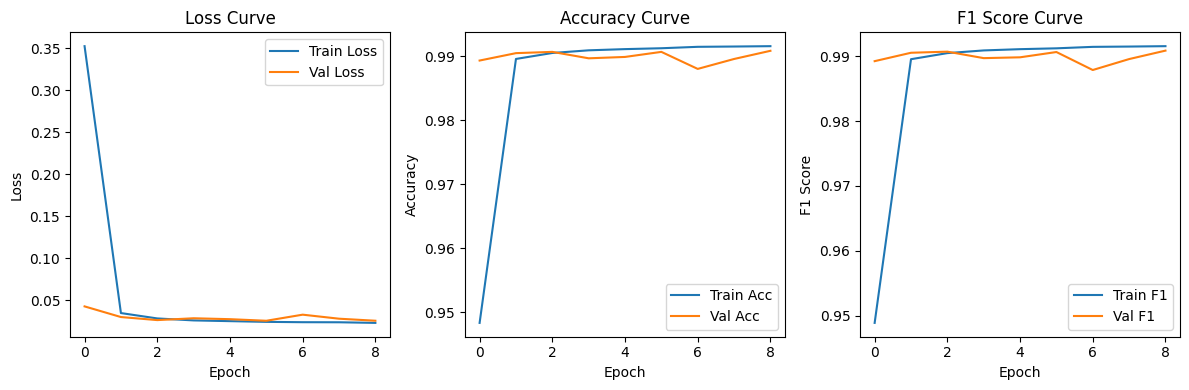

In [5]:
# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# F1
plt.subplot(1,3,3)
plt.plot(train_f1_list, label='Train F1')
plt.plot(val_f1_list, label='Val F1')
plt.title("F1 Score Curve")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# %%
job_codes = big5_df['Code'].tolist()

from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(scaled_features)
# similarity_matrix.shape = (263, 263)


def recommend_jobs(user_big5_scores, model, similarity_matrix, top_k=10):
    model.eval()
    with torch.no_grad():
        # 标准化用户输入
        user_scaled = scaler.transform([user_big5_scores])
        user_tensor = torch.tensor(user_scaled, dtype=torch.float32)

        # MLP 输出 logits
        logits = model(user_tensor).numpy().flatten()

        # 计算 similarity-aware score（逻辑输出 × 相似度）
        match_score = similarity_matrix @ logits

        # 取 Top-k
        top_indices = np.argsort(match_score)[-top_k:][::-1]
        top_jobs = [(job_codes[i], job_names[i], match_score[i]) for i in top_indices]  # 加上代码

        return top_jobs

user_input = [51.46,	51.17,	46.09,	52.15,	49.41]

recommendations = recommend_jobs(user_input, model, similarity_matrix, top_k=10)

for i, (code, job, score) in enumerate(recommendations):
    print(f"{i+1}. {code} - {job} (score: {score:.2f})")

1. 2342 - Early Childhood Educators (score: 4585.37)
2. 2341 - Primary School Teachers (score: 4285.71)
3. 3431 - Photographers (score: 4251.07)
4. 5244 - Contact Centre Salespersons (score: 4164.31)
5. 2352 - Special Needs Teachers (score: 4099.73)
6. 5311 - Child Care Workers (score: 4072.06)
7. 5312 - Teachers’ Aides (score: 3958.71)
8. 5321 - Health Care Assistants (score: 3770.35)
9. 2166 - Graphic and Multimedia Designers (score: 3712.71)
10. 2635 - Social Work and Counselling Professionals (score: 3595.56)


C:\Users\L\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [7]:

# 假设你的模型是 model
torch.save(model.state_dict(), "your_model.pth")

# 假设你已经对特征使用了 scaler
scaler = StandardScaler()
scaler.fit(X_train)  # 这里 X_train 是你训练数据的特征
joblib.dump(scaler, "your_scaler.pkl")


# 假设 job_names 和 job_codes 是你拥有的职业名称和代码列表
job_names = big5_df['Job'].tolist() # 你的职业名称列表
job_codes = big5_df['Code'].tolist() # 你的职业代码列表

# 保存为 numpy 文件
np.save("job_names.npy", job_names)
np.save("job_codes.npy", job_codes)



# 保存标准化后的职业特征
np.save("scaled_features.npy", scaled_features)


# 保存相似度矩阵
np.save("similarity_matrix.npy", similarity_matrix)




